<a href="https://colab.research.google.com/github/SamoaChen/Frequentist-ML/blob/main/Gradient_Boosted_Tree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install xgboost

In [112]:
import pandas as pd
from sklearn.model_selection import train_test_split
import xgboost as xgb
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.inspection import plot_partial_dependence
from sklearn.ensemble import GradientBoostingRegressor

data = '/content/drive/My Drive/Colab Notebooks/ML_HW4/housing.csv'
housing = pd.read_csv(data, sep=',', header=0)
housing

,median_house_value,median_income,housing_median_age,total_rooms,total_bedrooms,population,households,latitude,longitude
0,452600,8.3252,41,880,129,322,126,37.88,-122.23
1,358500,8.3014,21,7099,1106,2401,1138,37.86,-122.22
2,352100,7.2574,52,1467,190,496,177,37.85,-122.24
3,341300,5.6431,52,1274,235,558,219,37.85,-122.25
4,342200,3.8462,52,1627,280,565,259,37.85,-122.25
...,...,...,...,...,...,...,...,...,...
20635,78100,1.5603,25,1665,374,845,330,39.48,-121.09
20636,77100,2.5568,18,697,150,356,114,39.49,-121.21
20637,92300,1.7000,17,2254,485,1007,433,39.43,-121.22
20638,84700,1.8672,18,1860,409,741,349,39.43,-121.32


In [113]:
#-------------------SEPERATE TRAIN VALID AND TEST SETS
housing_train , housing_remain = train_test_split(housing, test_size=0.2, random_state=100, shuffle=True)
housing_valid , housing_test = train_test_split(housing_remain, test_size=0.5, random_state=100, shuffle=True)

#SEPERATE X AND Y VALUES
h_trainx = housing_train.drop(['median_house_value'], axis=1)
h_trainy = housing_train['median_house_value']

h_validx = housing_valid.drop(['median_house_value'], axis=1)
h_validy = housing_valid['median_house_value']

h_testx = housing_test.drop(['median_house_value'], axis=1)
h_testy = housing_test['median_house_value']

#STANDARDIZE DATA
h_trainx=(h_trainx-h_trainx.mean())/h_trainx.std(ddof=1)
h_validx=(h_validx-h_validx.mean())/h_validx.std(ddof=1)
h_testx=(h_testx-h_testx.mean())/h_testx.std(ddof=1)

In [114]:
#---------------XGBoost TRAINING
params = {'n_estimators': 800, 'max_depth': 4, 'learning_rate': 0.1, 'loss': 'huber', 'random_state':42}
xgb_housing = GradientBoostingRegressor(**params)
xgb_housing.fit(h_trainx,h_trainy)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='huber',
                          max_depth=4, max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=800,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

Huber loss has regularization embeded already, so the L1, L2 coefficient are left blank, the max_depth is chose to be one unit larger than the conventional value, which improves the test set accuracy.

Text(0, 0.5, 'Deviance')

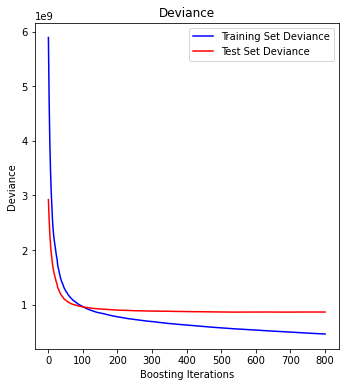

In [50]:
#COMPUTE TEST SET DEVIANCE
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)

for i, y_pred in enumerate(xgb_housing.staged_predict(h_testx)):
    test_score[i] = xgb_housing.loss_(h_testy, y_pred)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, xgb_housing.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')

The training set error keeps decreasing when the iteration increases, but the error for testing set started to plateu after about 100 iteration. Both traing and testing has a relatively significant drop in error for the first 100 data set.

In [ ]:
#--------------PLOT ERROR FOR DIFFERENT NUMBER OF ITERATION
#PLACE TO STORE ERROR
iterations = 500
abs_train_err_vec = np.zeros(iterations)
abs_test_err_vec = np.zeros(iterations)
iteration_vec = np.arange(iterations)
#LOOP THROUGH DIFFERENT ITERATION TO CALCULATE ERROR
for index in iteration_vec:
  xgb_housing = GradientBoostingRegressor(n_estimators=index+1,loss='huber',max_depth=4,random_state=42)
  xgb_housing.fit(h_trainx,h_trainy)
  #TABULATING TRAINING ERROR
  pred = xgb_housing.predict(h_trainx)
  #xgb_housing = xgb.XGBRegressor(n_estimators=index, objective='reg:squarederror', max_depth=4, learning_rate=0.1, missing=None, seed=42)
  #xgb_housing.fit(h_trainx, h_trainy, verbose=True)
  #pred = xgb_housing.predict(h_validx)
  abs_train_err = (np.abs(h_trainy-pred)).mean()
  abs_train_err_vec[index] = abs_train_err
  #TABULATING TESTING ERROR
  pred = xgb_housing.predict(h_validx)
  abs_test_err = (np.abs(h_validy-pred)).mean()
  abs_test_err_vec[index] = abs_test_err
  

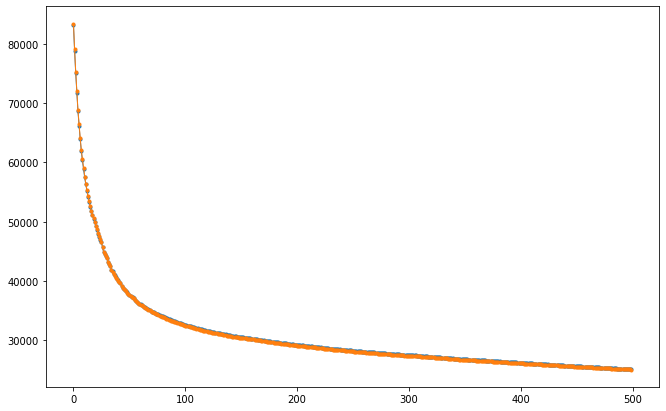

In [ ]:
plt.figure(figsize=(11,7))

plt.plot(iteration_vec,abs_test_err_vec,marker='.',linewidth=1)
plt.plot(iteration_vec,abs_train_err_vec,marker='.',linewidth=1)

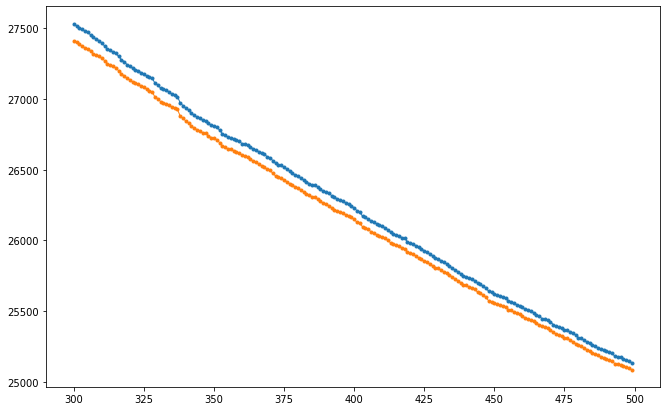

In [ ]:
plt.figure(figsize=(11,7))

plt.plot(iteration_vec[300:],abs_test_err_vec[300:],marker='.',linewidth=1)
plt.plot(iteration_vec[300:],abs_train_err_vec[300:],marker='.',linewidth=1)

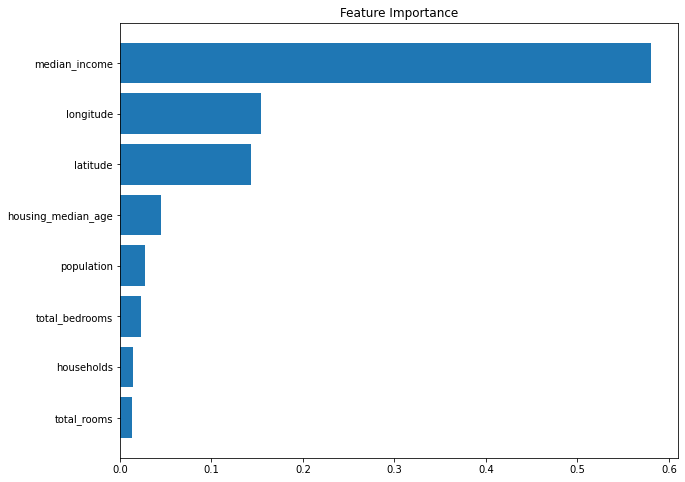

In [51]:
#---------------PLOT RELATIVE IMPORTANCE
feature_names = h_trainx.columns
feature_importance = xgb_housing.feature_importances_
sorted_idx = feature_importance.argsort()
y_ticks = np.arange(0, h_trainx.shape[1])
fig, ax = plt.subplots(figsize=(10, 8))
ax.barh(y_ticks, feature_importance[sorted_idx])
ax.set_yticklabels(feature_names[sorted_idx])
ax.set_yticks(y_ticks)
ax.set_title("Feature Importance")
plt.show()

T feature with the most importance is median income, which matches with the resullt from the textbook and also with common sense, since icome of house hold represent their ability to purchase, so could represent their house price. The high importance of longitude and latitude are mostly because of the high real estate price at major cities.

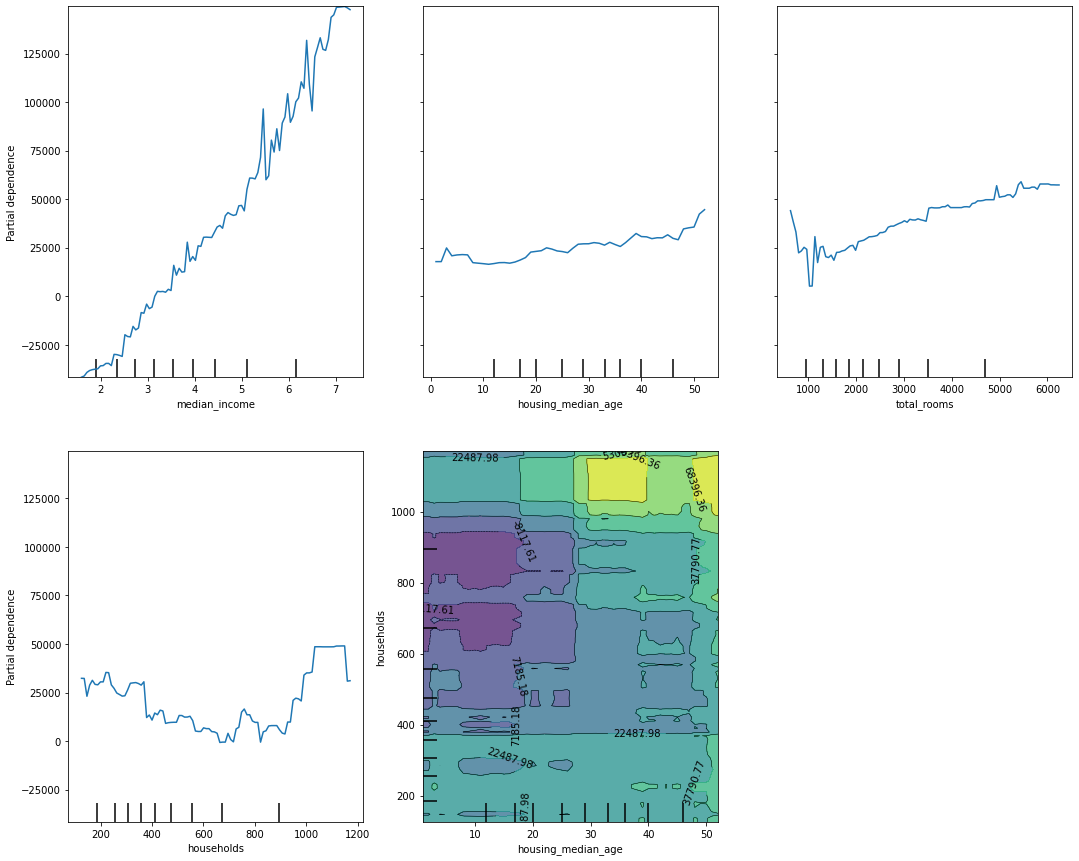

In [115]:
#--------------PLOT PDP
fig, ax = plt.subplots(figsize=(18, 15))
features = [0, 1, 2, 5, (1, 5)]
plot_partial_dependence(xgb_housing,h_trainx,features,ax=ax)
plt.show()

(Note the those plots are plotted without standardizing the data, so they still have their original unit)As it is shown in the first median income partial dependence plot, the relationship is always linear between median income and house value,and data clustered at about the median value. The relatively flat curve of the partial dependence plot for housing age and rooms shows a less influence of them on the house value compare to median income. The plot for household number has a downward kink, at around 600, which could be caused by lack of data at that range.The same analysis can be applied to high household range.

In [40]:
#REPEAT THE ANALYSIS ON THE CANCER DATASET
data = '/content/drive/My Drive/Colab Notebooks/ML_HW4/cancer.txt'
prostate_data = pd.read_table(data,usecols=[1,2,3,4,5,6,7,8,9])


,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45,lpsa
0,-0.579818,2.769459,50,-1.386294,0,-1.386294,6,0,-0.430783
1,-0.994252,3.319626,58,-1.386294,0,-1.386294,6,0,-0.162519
2,-0.510826,2.691243,74,-1.386294,0,-1.386294,7,20,-0.162519
3,-1.203973,3.282789,58,-1.386294,0,-1.386294,6,0,-0.162519
4,0.751416,3.432373,62,-1.386294,0,-1.386294,6,0,0.371564
...,...,...,...,...,...,...,...,...,...
92,2.830268,3.876396,68,-1.386294,1,1.321756,7,60,4.385147
93,3.821004,3.896909,44,-1.386294,1,2.169054,7,40,4.684443
94,2.907447,3.396185,52,-1.386294,1,2.463853,7,10,5.143124
95,2.882564,3.773910,68,1.558145,1,1.558145,7,80,5.477509


In [109]:
#-------------------SEPERATE TRAIN VALID AND TEST SETS
cancer_train , cancer_remain = train_test_split(prostate_data, test_size=0.2, random_state=42, shuffle=True)
cancer_valid , cancer_test = train_test_split(cancer_remain, test_size=0.5, random_state=42, shuffle=True)

#SEPERATE X AND Y VALUES
c_trainx = cancer_train.drop(['lpsa'], axis=1)
c_trainy = cancer_train['lpsa']

c_validx = cancer_valid.drop(['lpsa'], axis=1)
c_validy = cancer_valid['lpsa']

c_testx = cancer_test.drop(['lpsa'], axis=1)
c_testy = cancer_test['lpsa']

#STANDARDIZE DATA
c_trainx=(c_trainx-c_trainx.mean())/c_trainx.std(ddof=1)
c_validx=(c_validx-c_validx.mean())/c_validx.std(ddof=1)
c_testx=(c_testx-c_testx.mean())/c_testx.std(ddof=1)

In [110]:
#---------------XGBoost TRAINING
params_cancer = {'n_estimators': 1000, 'max_depth': 2, 'learning_rate': 0.01, 'loss': 'huber', 'random_state':42}
xgb_cancer = GradientBoostingRegressor(**params_cancer)
xgb_cancer.fit(c_trainx,c_trainy)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.01, loss='huber',
                          max_depth=2, max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=1000,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

Because the relatively small sample size, the depth of tree is chosen to be 2 to avoid over fitting. And the learning rate is also set at a lower value at 0.01

Text(0, 0.5, 'Deviance')

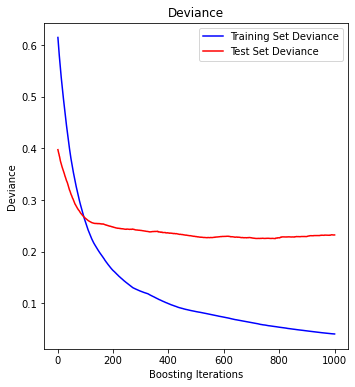

In [108]:
#COMPUTE TEST SET DEVIANCE
test_score = np.zeros((params_cancer['n_estimators'],), dtype=np.float64)

for i, y_pred in enumerate(xgb_cancer.staged_predict(c_testx)):
    test_score[i] = xgb_cancer.loss_(c_testy, y_pred)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Deviance')
plt.plot(np.arange(params_cancer['n_estimators']) + 1, xgb_cancer.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params_cancer['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')

The deviance is rather large between test and training. An possible explanation is the sample size is too small. The test error also plateu after about 200 iterations.

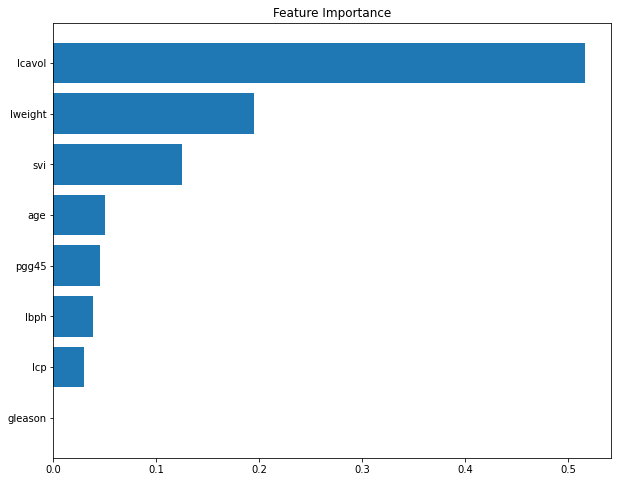

In [67]:
#---------------PLOT RELATIVE IMPORTANCE
feature_names = c_trainx.columns
feature_importance = xgb_cancer.feature_importances_
sorted_idx = feature_importance.argsort()
y_ticks = np.arange(0, c_trainx.shape[1])
fig, ax = plt.subplots(figsize=(10, 8))
ax.barh(y_ticks, feature_importance[sorted_idx])
ax.set_yticklabels(feature_names[sorted_idx])
ax.set_yticks(y_ticks)
ax.set_title("Feature Importance")
plt.show()

The most important feature predicted is lcavol, which matches with the result from HW1

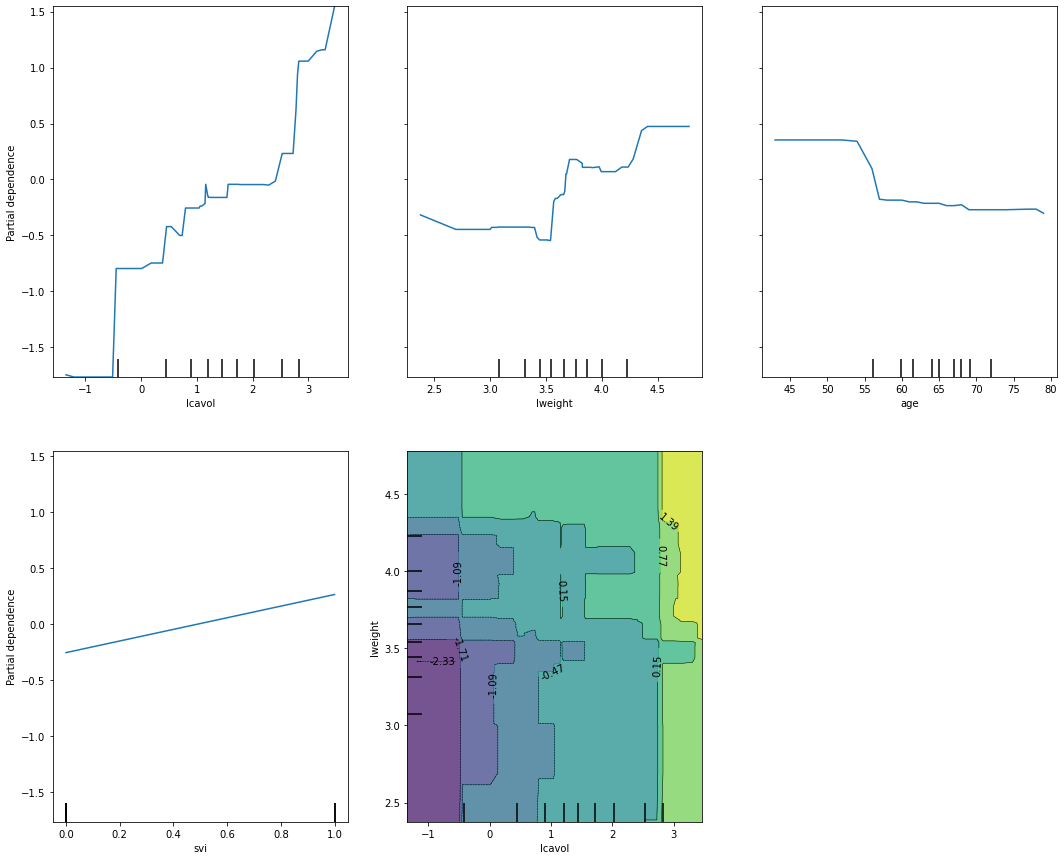

In [111]:
#--------------PLOT PDP
fig, ax = plt.subplots(figsize=(18, 15))
features = [0, 1, 2, 4, (0, 1)]
plot_partial_dependence(xgb_cancer,c_trainx,features,ax=ax)
plt.show()

Those plots are rather not smooth, which is resulted from lacking data. From lcavol's plot, a possible linear relationship can be infered, as the lable value increase with increasing lcavol value. There seems to be a negative effect from age, but there is scarce data for age below 55. Other features shows a positive relationship with lpsa. The last pair PD plot matches with the results from features individual partial dependence plots.

In [ ]:
#------------IMPLEMENT GRADIENT BOOST WITH SIMPLE TREE
from sklearn.tree import DecisionTreeRegressor

In [ ]:
#------------FUNCTIONS FOR GRADIENT BOOSTING TREE
#GRADIENT BOOSTING REGRESSOR USING MEAN SQURE ERROR
def gbr_mse(h_train_x, h_train_y, iteration, rate, tree_depth, leaf_num):
  reg_vec = []
  iteration_vec = np.arange(iteration)
  #COMPUTE THE FIRST RESIDULE
  residule =  h_trainy-h_train_y.mean()
  #FIRST PREDICTION
  pred = h_trainy
  pred.replace(h_trainy.to_numpy(),h_trainy.mean())
  #LOOP TO COMPUTE ALL ITERATIONS
  for num in iteration_vec:
    reg_new = DecisionTreeRegressor(criterion='mse',max_depth=tree_depth,max_leaf_nodes=leaf_num)
    reg_new.fit(h_trainx, residule)
    reg_vec.append(reg_new)
    #COMPUTE NEW RESIDULE
    pred = pred + rate*reg_vec[num].predict(h_trainx)
    residule = h_trainy - pred

  return reg_vec

#GBR USING MSE PREDICTION
def prediction(h_testx, model, rate):
  #FIRST PREDICTION
  pred = h_testy
  pred.replace(h_testy.to_numpy(),h_testy.mean())
  #FIND PREDICTED VALUE USING MODEL
  for num in np.arange(len(model)):
    pred = pred+rate*model[num].predict(h_testx)

  return pred



In [ ]:
#----------CALCULATING GRADIENT BOOSTING REGRESSOR USING MSE
model = gbr_mse(h_trainx, h_trainy, 100, 0.01, 5, 9)
#PREDICT FOR TEST SET
pred = prediction(h_testx, model, 0.01)

abs_err_base = (np.abs(h_testy-h_testy.mean())).mean()
abs_err_gbr = (np.abs(h_testy-pred)).mean()

print("The base case absolute error is : ", abs_err_base)
print("The absolute error calculated using gbr : ", abs_err_gbr)

The base case absolute error is :  91552.0246738493
The absolute error calculated using gbr :  227.91732105414962
